In [8]:
%reload_ext autoreload
%autoreload 2

import json
import os
import sys
from pathlib import Path

import boto3
import joblib
import numpy as np
import optuna
import polars as pl
import sagemaker
from hydra import compose, core, initialize
from lightgbm.callback import early_stopping
from omegaconf import OmegaConf
from sagemaker.estimator import Estimator
from sklearn.base import clone
from sklearn.metrics import average_precision_score, classification_report, make_scorer
from xgboost import XGBClassifier

sys.path.append(str(Path(os.getcwd()).parents[0]))
from src.model_utils import get_db_url, save_or_load_permutation_importance
from src.plot_utils import (
    StudyVisualizer,
    plot_calibration_curve,
    plot_confusion_matrix,
    plot_cost_curve,
    plot_permutation_importances,
    plot_precision_recall_curve,
    plot_prediction_vs_groundtruth,
)

## Hydra

In [3]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base="1.2", config_path="../src/config", job_name="classification")
config = OmegaConf.to_container(compose(config_name="main"), resolve=True)

In [4]:
random_state = np.random.RandomState(config["random_seed"])

## S3

In [5]:
s3_data_prefix = f"s3://{config['s3_bucket']}/data/"
s3_terraform_state = "s3://tf-cf-templates/terraform-states/fraud-detection/ml-training/terraform.tfstate"
s3_client = boto3.client("s3")

train_channel = {
    "train": sagemaker.inputs.TrainingInput(
        s3_data=f"{s3_data_prefix}train/",
        distribution="FullyReplicated",
        content_type="application/x-parquet",
        s3_data_type="S3Prefix",
        input_mode="File",
    )
}

train_channel

{'train': <sagemaker.inputs.TrainingInput at 0x3192546d0>}

In [6]:
data_sets = {}
for data_set in ["train", "val", "test"]:
    data_sets[data_set] = pl.read_parquet(
        os.path.join(s3_data_prefix, f"{data_set}/{data_set}.parquet")
    )

X_train = data_sets["train"].drop(
    [config["features"]["target"], config["features"]["id"]]
)
y_train = (
    data_sets["train"][config["features"]["target"]].to_numpy().ravel().astype(int)
)

X_val = data_sets["val"].drop([config["features"]["target"], config["features"]["id"]])
y_val = data_sets["val"][config["features"]["target"]].to_numpy().ravel().astype(int)

X_test = data_sets["test"].drop(
    [config["features"]["target"], config["features"]["id"]]
)
y_test = data_sets["test"][config["features"]["target"]].to_numpy().ravel().astype(int)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

[01/03/25 20:27:39] INFO     Loading cached SSO token for sso-session                                 ]8;id=961537;file:///Users/yang_wu/pyapp/credit_card_fraud_detection/.venv/lib/python3.11/site-packages/botocore/tokens.py\tokens.py]8;;\:]8;id=681576;file:///Users/yang_wu/pyapp/credit_card_fraud_detection/.venv/lib/python3.11/site-packages/botocore/tokens.py#305\305]8;;\

[01/03/25 20:27:46] INFO     Loading cached SSO token for sso-session                                 ]8;id=959756;file:///Users/yang_wu/pyapp/credit_card_fraud_detection/.venv/lib/python3.11/site-packages/botocore/tokens.py\tokens.py]8;;\:]8;id=473359;file:///Users/yang_wu/pyapp/credit_card_fraud_detection/.venv/lib/python3.11/site-packages/botocore/tokens.py#305\305]8;;\

[01/03/25 20:27:50] INFO     Loading cached SSO token for sso-session                                 ]8;id=863184;file:///Users/yang_wu/pyapp/credit_card_fraud_detection/.venv/lib/python3.11/site-packages/botocore/tokens.py\tokens.py]8;;\:]8;id=724317;file:///Users/yang_wu/pyapp/credit_card_fraud_detection/.venv/lib/python3.11/site-packages/botocore/tokens.py#305\305]8;;\

Training set shape: (393182, 231)
Validation set shape: (196591, 231)
Test set shape: (98294, 231)


## SageMaker

In [7]:
sagemaker_session = sagemaker.Session(default_bucket=config["s3_bucket"])
sm_client = boto3.client("sagemaker")
role = sagemaker.get_execution_role()

[01/03/25 20:27:53] INFO     Loading cached SSO token for sso-session                                 ]8;id=630634;file:///Users/yang_wu/pyapp/credit_card_fraud_detection/.venv/lib/python3.11/site-packages/botocore/tokens.py\tokens.py]8;;\:]8;id=690973;file:///Users/yang_wu/pyapp/credit_card_fraud_detection/.venv/lib/python3.11/site-packages/botocore/tokens.py#305\305]8;;\

## Database Connection String

Construct the database connection string, which will be used by optuna to write the study results to the database:

In [34]:
!aws s3 cp {s3_terraform_state} /tmp/terraform.tfstate

with open("/tmp/terraform.tfstate") as file:
    terraform_state = json.load(file)

outputs = {key: data["value"] for key, data in terraform_state["outputs"].items()}

download: s3://tf-cf-templates/terraform-states/fraud-detection/ml-training/terraform.tfstate to ../../../../../tmp/terraform.tfstate


In [35]:
host = outputs["rds_cluster_endpoint"]
db_name = outputs["rds_database_name"]
db_secret = outputs["rds_creds_secret_arn"].split(":")[-1].split("-")[0]

db_url = get_db_url(
    host=host,
    db_name=db_name,
    db_secret=db_secret,
    region_name=sagemaker_session._region_name,
)

[01/03/25 20:17:58] INFO     Loading cached SSO token for sso-session                                 ]8;id=661980;file:///Users/yang_wu/pyapp/credit_card_fraud_detection/.venv/lib/python3.11/site-packages/botocore/tokens.py\tokens.py]8;;\:]8;id=394714;file:///Users/yang_wu/pyapp/credit_card_fraud_detection/.venv/lib/python3.11/site-packages/botocore/tokens.py#305\305]8;;\

## Subnets & Security Groups for Training Jobs

In [36]:
subnets = outputs["private_subnets"].split(",")
security_groups_ids = [outputs["sagemaker_security_group"]]

## XGBoost Training Job

### Docker Image

In [ ]:
!cd {config["docker_dir_path"]} && bash ./build_and_push.sh xgboost-latest train.xgb {config["ecr_repository"]} 

In [13]:
images = !aws ecr list-images --repository-name {config['ecr_repository']}
images_str = "\n".join(images)
images_str = json.loads(images_str)

for ecr_meta_data_dict in images_str["imageIds"]:
    if "imageTag" in ecr_meta_data_dict and ecr_meta_data_dict["imageTag"].startswith(
        "xgboost"
    ):
        train_image_tag_xgb = ecr_meta_data_dict["imageTag"]

train_image_uri_xgb = f"{sagemaker_session.account_id()}.dkr.ecr.{sagemaker_session.boto_region_name}.amazonaws.com/{config['ecr_repository']}:{train_image_tag_xgb}"

### Test Locally

In [12]:
# This helps ensure the tmp files are cleared before each run of the test
!sudo rm -rf /tmp/tmp*

In [ ]:
test_study_xgb = "test_study"

test_estimator_xgb = Estimator(
    # Sagemaker
    image_uri=train_image_uri_xgb,
    role=role,
    instance_type="local",
    instance_count=config["xgboost"]["instance_count"],
    model_dir=config["model_dir"],
    output_path=config["output_path"],
    code_location=config["code_location"],
    volume_size=config["volume_size"],
    # Optuna
    subnets=subnets,
    security_group_ids=security_groups_ids,
    hyperparameters={
        "host": host,
        "db_name": db_name,
        "study_name": test_study_xgb,
        "db_secret": db_secret,
        "region_name": sagemaker_session._region_name,
        "n_trials": 2,
        "test_mode": 1,
    },
)

test_estimator_xgb.fit(inputs=train_channel, wait=True)

In [ ]:
optuna.study.delete_study(study_name=test_study_xgb, storage=db_url)

### Hyperparameter Optimization

In [13]:
estimator_xgb = Estimator(
    # Sagemaker
    image_uri=train_image_uri_xgb,
    role=role,
    instance_type=config["xgboost"]["instance_type"],
    instance_count=config["xgboost"]["instance_count"],
    model_dir=config["model_dir"],
    output_path=config["output_path"],
    code_location=config["code_location"],
    volume_size=config["volume_size"],
    max_run=config["max_run"],
    base_job_name=config["xgboost"]["base_job_name"],
    sagemaker_session=sagemaker_session,
    # Spot training
    max_wait=config["max_wait"],
    max_retry_attempts=config["max_retry_attempts"],
    checkpoint_s3_uri=os.path.join(config["checkpoint_s3_uri"], "xgboost"),
    use_spot_instances=config["use_spot_instances"],
    # Optuna
    subnets=subnets,
    security_group_ids=security_groups_ids,
    hyperparameters={
        "host": host,
        "db_name": db_name,
        "study_name": config["xgboost"]["study_name"],
        "db_secret": db_secret,
        "region_name": sagemaker_session._region_name,
        "n_trials": 25,
        "test_mode": 0,
    },
)

estimator_xgb

In [ ]:
max_parallel_jobs = 4

for i in range(max_parallel_jobs - 1):
    estimator_xgb.fit(inputs=train_channel, wait=False)
estimator_xgb.fit(inputs=train_channel, wait=True)

#### Visualize HPO Results

In [13]:
study_xgb = optuna.study.load_study(
    study_name=config["xgboost"]["study_name"], storage=db_url
)

hpo_visualizer_xgb = StudyVisualizer(study=study_xgb)
hpo_visualizer_xgb

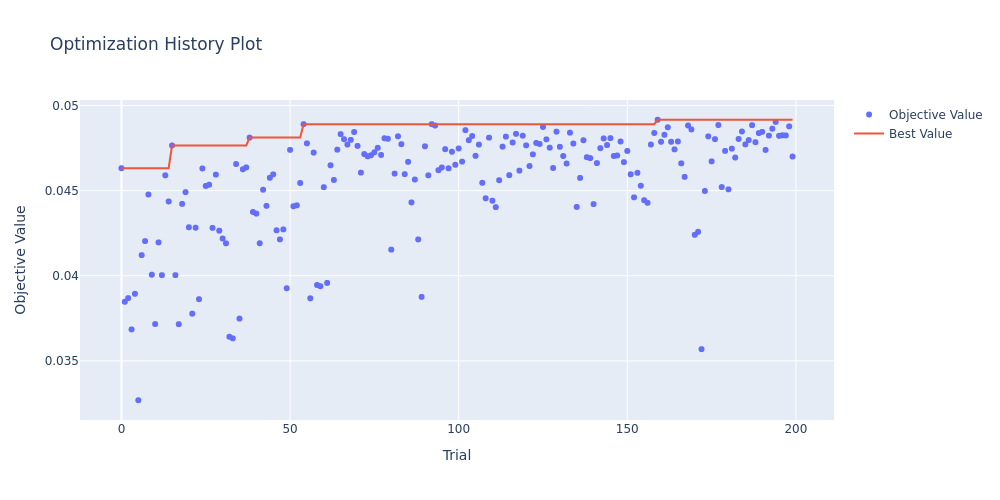

In [17]:
hpo_visualizer_xgb.plot_optimization_history(figsize=(1000, 500))

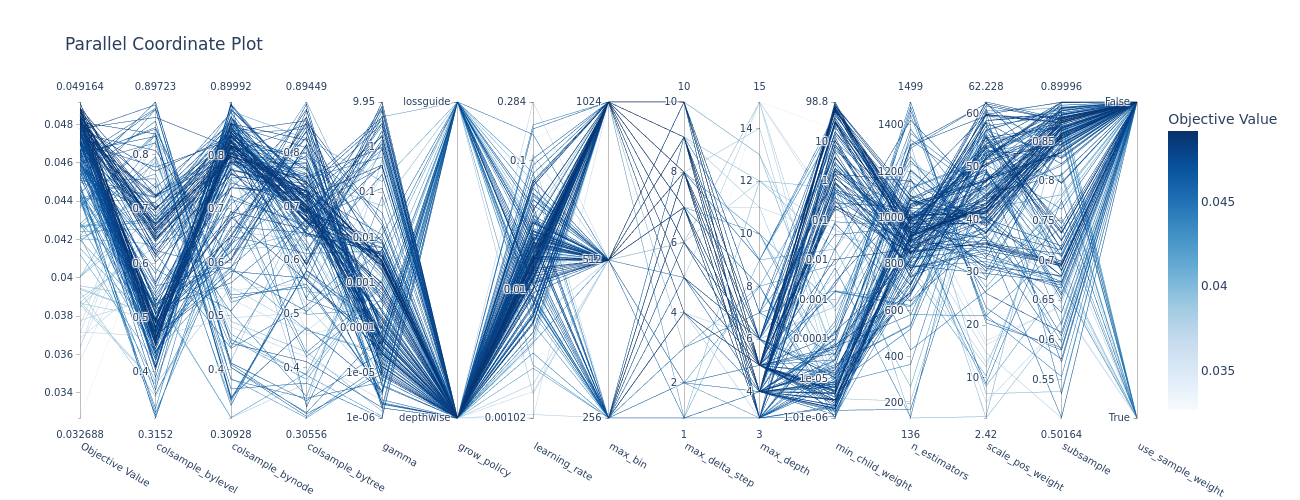

In [18]:
hpo_visualizer_xgb.plot_parallel_coordinate(
    figsize=(1300, 500),
    params=[
        "n_estimators",
        "max_depth",
        "learning_rate",
        "gamma",
        "max_delta_step",
        "min_child_weight",
        "subsample",
        "colsample_bytree",
        "colsample_bylevel",
        "colsample_bynode",
        "max_bin",
        "grow_policy",
        "use_sample_weight",
        "scale_pos_weight",
    ],
)

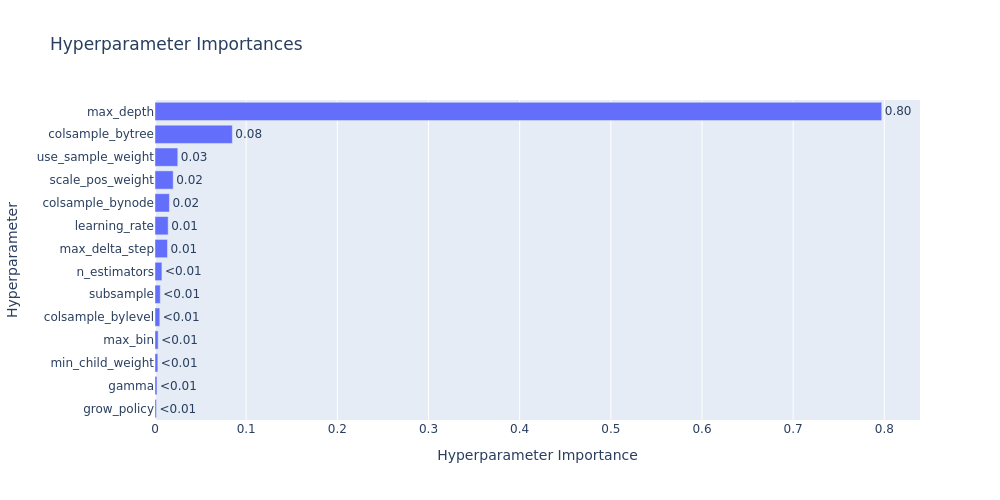

In [19]:
hpo_visualizer_xgb.plot_param_importances(figsize=(1000, 500))

### Best Model

In [14]:
best_model_s3_path_xgb = sm_client.describe_training_job(
    TrainingJobName=study_xgb.best_trial.user_attrs["job_name"]
)["ModelArtifacts"]["S3ModelArtifacts"]

print(f"Best model artifacts persisted at {best_model_s3_path_xgb}")

Best model artifacts persisted at s3://fraud-detection-classification/models/xgboost-training-2024-12-23-21-43-51-043/output/model.tar.gz


In [15]:
!aws s3 cp $best_model_s3_path_xgb /tmp/model.tar.gz
!tar -xvzf /tmp/model.tar.gz -C /tmp

download: s3://fraud-detection-classification/models/xgboost-training-2024-12-23-21-43-51-043/output/model.tar.gz to ../../../../../tmp/model.tar.gz
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
best_model.ubj


Load the model:

In [16]:
best_model_xgb = XGBClassifier()

best_model_xgb.load_model("/tmp/best_model.ubj")

best_model_xgb

XGBClassifier(base_score='4.0471968E-1', booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
y_val_prob_xgb = best_model_xgb.predict_proba(X_val)[:, 1]

### Permutation Feature Importance

In [17]:
write_mode = False
if write_mode:
    perm_feat_imp_result_xgb = save_or_load_permutation_importance(
        estimator=best_model_xgb,
        X=X_val,
        y=y_val,
        model_s3_path=best_model_s3_path_xgb,
        write_mode=write_mode,
        scoring_function=make_scorer(
            average_precision_score,
            response_method="predict_proba",
            greater_is_better=True,
        ),
        random_state=random_state,
    )
else:
    perm_feat_imp_result_xgb = save_or_load_permutation_importance(
        estimator=best_model_xgb,
        X=X_val,
        y=y_val,
        model_s3_path=best_model_s3_path_xgb,
        write_mode=write_mode,
    )

[12/26/24 16:50:08] INFO     Found credentials from IAM Role:                                   ]8;id=172565;file:///home/ec2-user/SageMaker/credit-card-fraud-detection/.venv/lib/python3.11/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=969329;file:///home/ec2-user/SageMaker/credit-card-fraud-detection/.venv/lib/python3.11/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

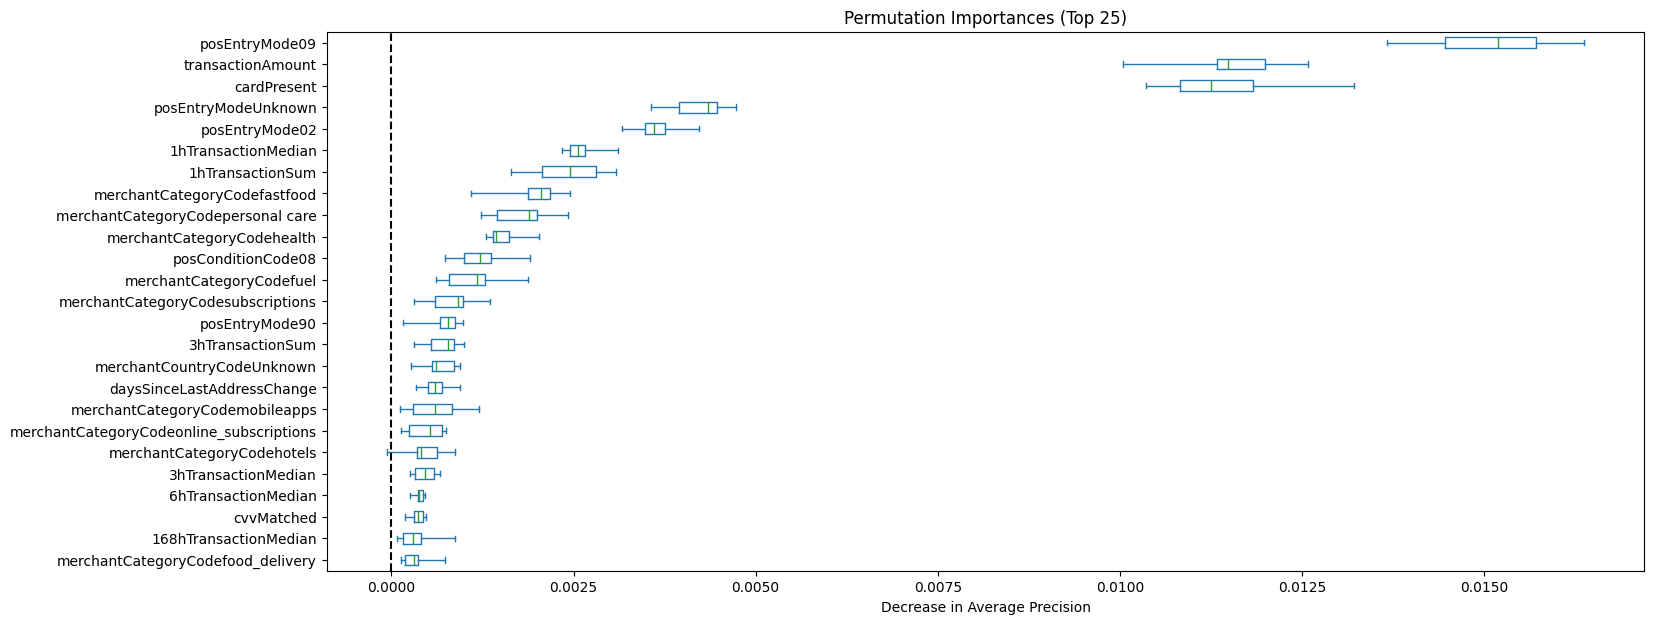

In [18]:
feat_impt_data = plot_permutation_importances(
    result=perm_feat_imp_result_xgb,
    feature_names=X_val.columns,
    top_k=25,
    metric_name="Average Precision",
    figsize=(17, 7),
)

### Calibration Curve

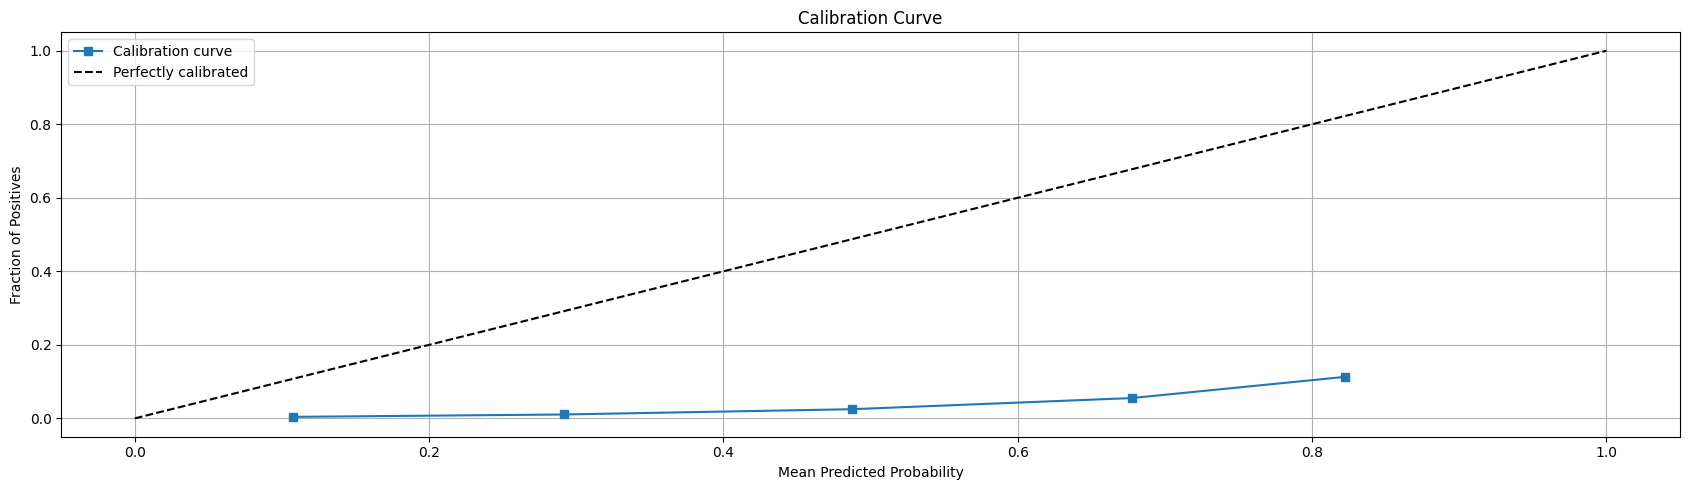

In [20]:
plot_calibration_curve(
    model=best_model_xgb,
    X=X_val,
    y_true=y_val,
    figsize=(17, 5),
)

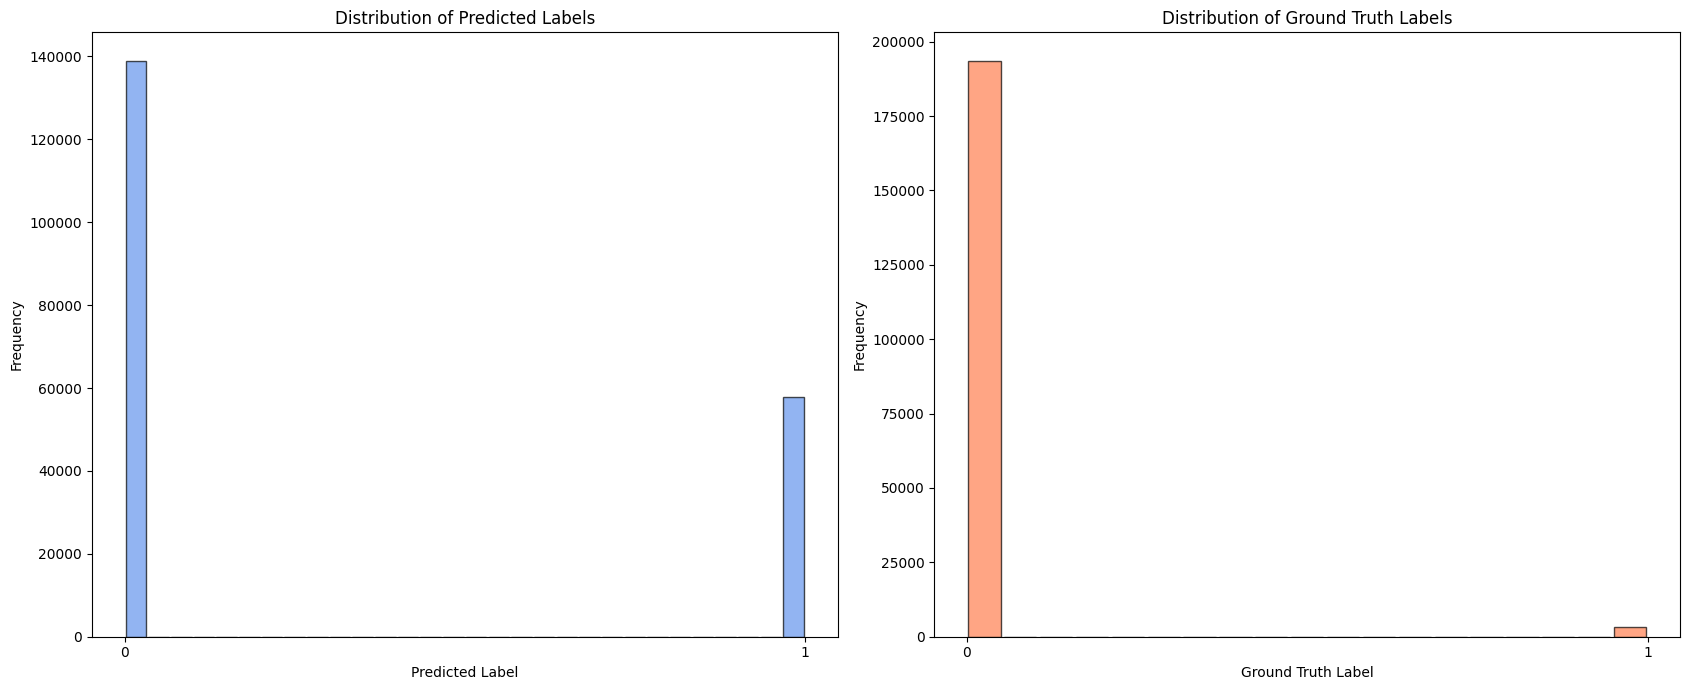

In [21]:
plot_prediction_vs_groundtruth(
    y_prob=y_val_prob_xgb,
    y_true=y_val,
    threshold=0.4,
    figsize=(17, 7),
)

### Cost Sensitive Treshold

We will make the following assumptions:

1. Cost of a false positive in fraud detection, i.e., manual review by a fraud analyst, ranges from $2$ to $8$ per transaction, computed based on an assumed range of review times ($5–15$ minutes) and hourly wages ($\$21$–$\$31$). Additional operational and opportunity costs may increase this estimate.

In [23]:
false_positive_cost = 5

2. The false negative cost for each undetection fraudulent transaction can be proxied by its transaction amount.

In [24]:
transaction_amounts_val = X_val["transactionAmount"].to_numpy()
transaction_amounts_val

array([101.46,   4.62,  42.98, ...,  60.21,  14.85,  12.8 ], dtype=float32)

We can plot the total cost of predictions on the validation set against a grid of decision thresholds:

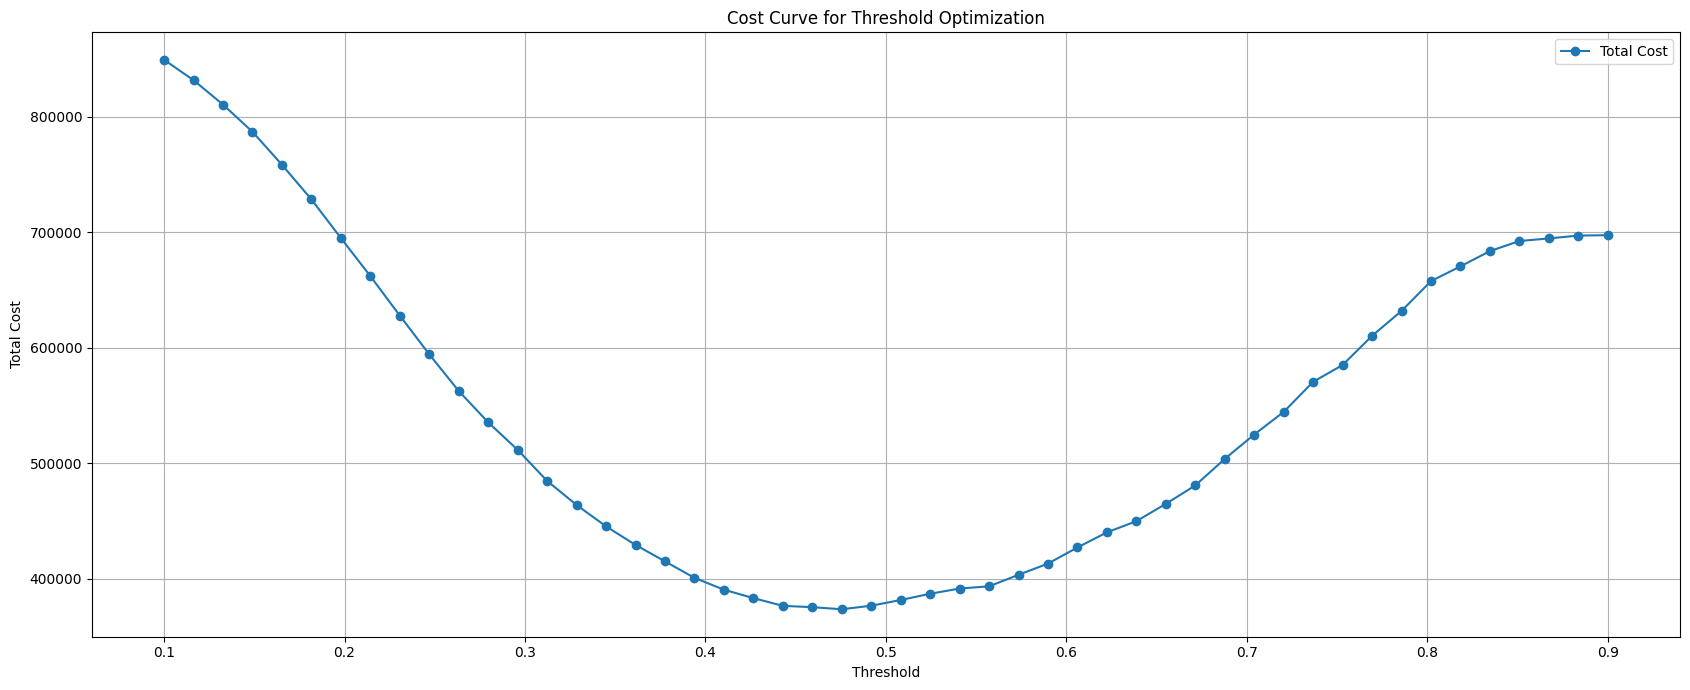

In [32]:
thresholds = np.linspace(0.10, 0.90, 50)

plot_cost_curve(
    y_prob=y_val_prob_xgb,
    y_true=y_val,
    transaction_amounts=transaction_amounts_val,
    false_positive_cost=false_positive_cost,
    thresholds=thresholds,
    figsize=(17, 7),
)

### Confusion Matrix

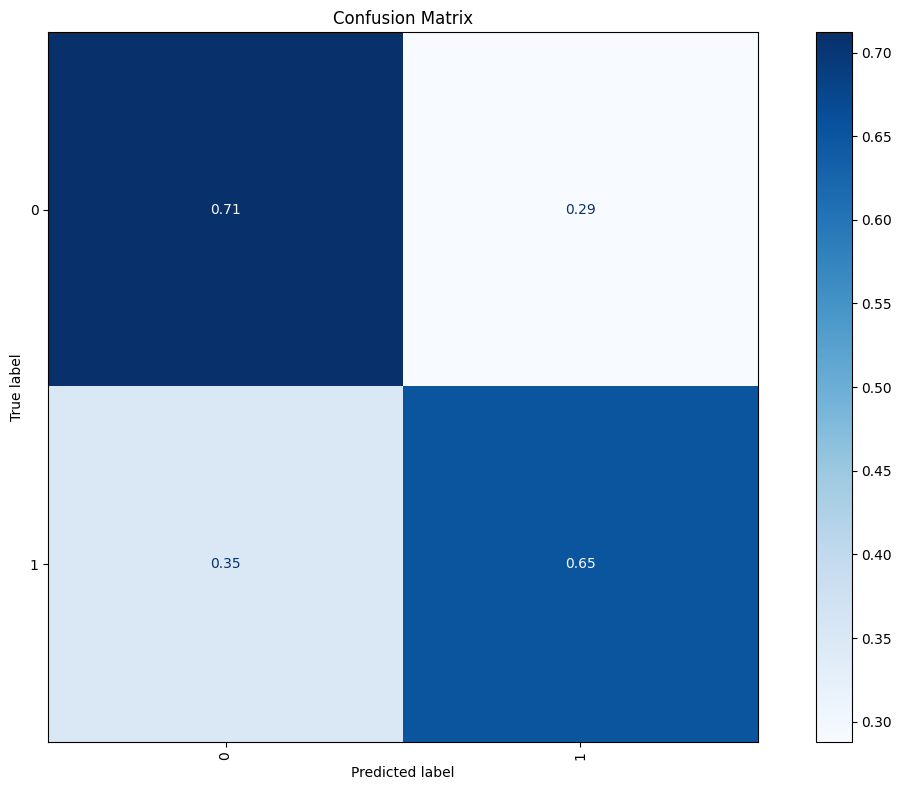

In [35]:
plot_confusion_matrix(
    model=best_model_xgb,
    X=X_val,
    y=y_val,
    figsize=(12, 8),
    threshold=0.4,
    normalize="true",
)

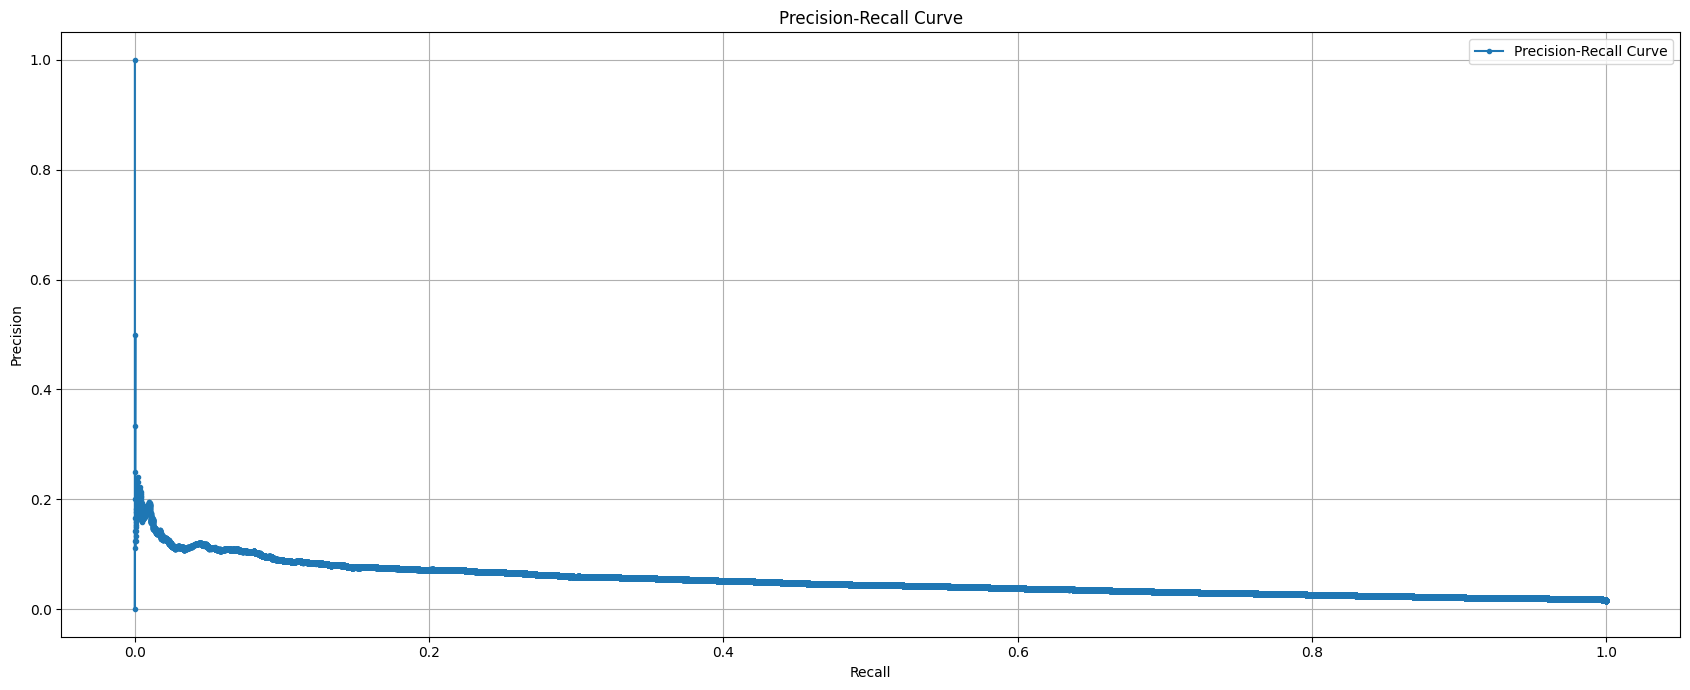

In [25]:
plot_precision_recall_curve(
    y_true=y_val,
    y_score=y_val_prob_xgb,
    figsize=(17, 7),
)

In [36]:
threshold = 0.4
print(classification_report(y_val, (y_val_prob_xgb > threshold).astype(int)))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83    193487
           1       0.03      0.65      0.07      3104

    accuracy                           0.71    196591
   macro avg       0.51      0.68      0.45    196591
weighted avg       0.98      0.71      0.82    196591



## LightGBM Training Job

### Docker Image

In [ ]:
!cd {config["docker_dir_path"]} && bash ./build_and_push.sh lightgbm-latest train.lgb {config["ecr_repository"]} 

In [12]:
images = !aws ecr list-images --repository-name {config['ecr_repository']}
images_str = "\n".join(images)
images_str = json.loads(images_str)

for ecr_meta_data_dict in images_str["imageIds"]:
    if "imageTag" in ecr_meta_data_dict and ecr_meta_data_dict["imageTag"].startswith(
        "lightgbm"
    ):
        train_image_tag_lgb = ecr_meta_data_dict["imageTag"]

train_image_uri_lgb = f"{sagemaker_session.account_id()}.dkr.ecr.{sagemaker_session.boto_region_name}.amazonaws.com/{config['ecr_repository']}:{train_image_tag_lgb}"

### Test Locally

In [ ]:
# This helps ensure the tmp files are cleared before each run of the test
!sudo rm -rf /tmp/tmp*

In [ ]:
test_study_lgb = "test_study"

test_estimator_lgb = Estimator(
    # Sagemaker
    image_uri=train_image_uri_lgb,
    role=role,
    instance_type="local",
    instance_count=config["lightgbm"]["instance_count"],
    model_dir=config["model_dir"],
    output_path=config["output_path"],
    code_location=config["code_location"],
    volume_size=config["volume_size"],
    # Optuna
    subnets=subnets,
    security_group_ids=security_groups_ids,
    hyperparameters={
        "host": host,
        "db_name": db_name,
        "study_name": test_study_lgb,
        "db_secret": db_secret,
        "region_name": sagemaker_session._region_name,
        "n_trials": 2,
        "test_mode": 1,
    },
)

test_estimator_lgb.fit(inputs=train_channel, wait=True)

In [25]:
optuna.study.delete_study(study_name=test_study_lgb, storage=db_url)

### Hyperparameter Optimization

In [26]:
estimator_lgb = Estimator(
    # Sagemaker
    image_uri=train_image_uri_lgb,
    role=role,
    instance_type=config["lightgbm"]["instance_type"],
    instance_count=config["lightgbm"]["instance_count"],
    model_dir=config["model_dir"],
    output_path=config["output_path"],
    code_location=config["code_location"],
    volume_size=config["volume_size"],
    max_run=config["max_run"],
    base_job_name=config["lightgbm"]["base_job_name"],
    sagemaker_session=sagemaker_session,
    # Spot training
    max_wait=config["max_wait"],
    max_retry_attempts=config["max_retry_attempts"],
    checkpoint_s3_uri=os.path.join(config["checkpoint_s3_uri"], "lightgbm"),
    use_spot_instances=config["use_spot_instances"],
    # Optuna
    subnets=subnets,
    security_group_ids=security_groups_ids,
    hyperparameters={
        "host": host,
        "db_name": db_name,
        "study_name": config["lightgbm"]["study_name"],
        "db_secret": db_secret,
        "region_name": sagemaker_session._region_name,
        "n_trials": 25,
        "test_mode": 0,
    },
)

estimator_lgb

In [ ]:
max_parallel_jobs = 4

for i in range(max_parallel_jobs - 1):
    estimator_lgb.fit(inputs=train_channel, wait=False)
estimator_lgb.fit(inputs=train_channel, wait=True)

#### Visualize HPO Results

In [8]:
study_lgb = optuna.study.load_study(
    study_name=config["lightgbm"]["study_name"], storage=db_url
)

hpo_visualizer_lgb = StudyVisualizer(study=study_lgb)
hpo_visualizer_lgb

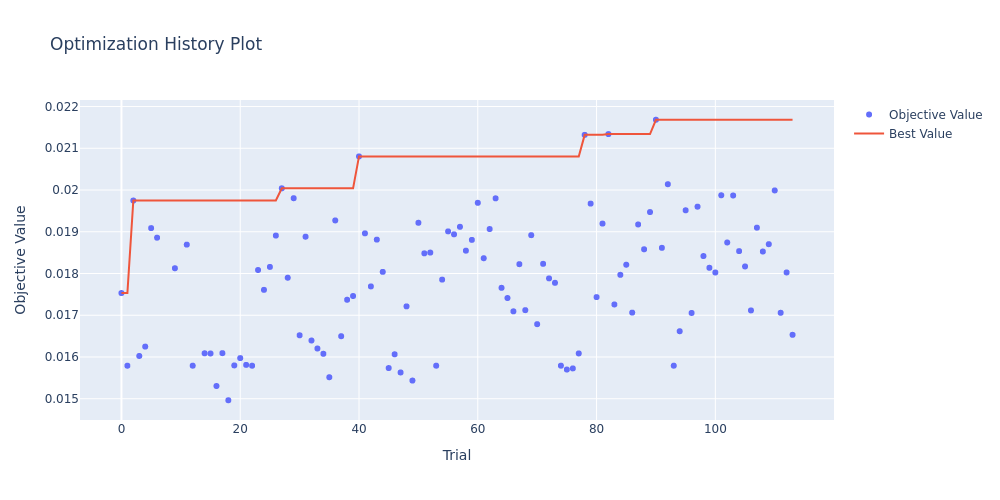

In [23]:
hpo_visualizer_lgb.plot_optimization_history(figsize=(1000, 500))

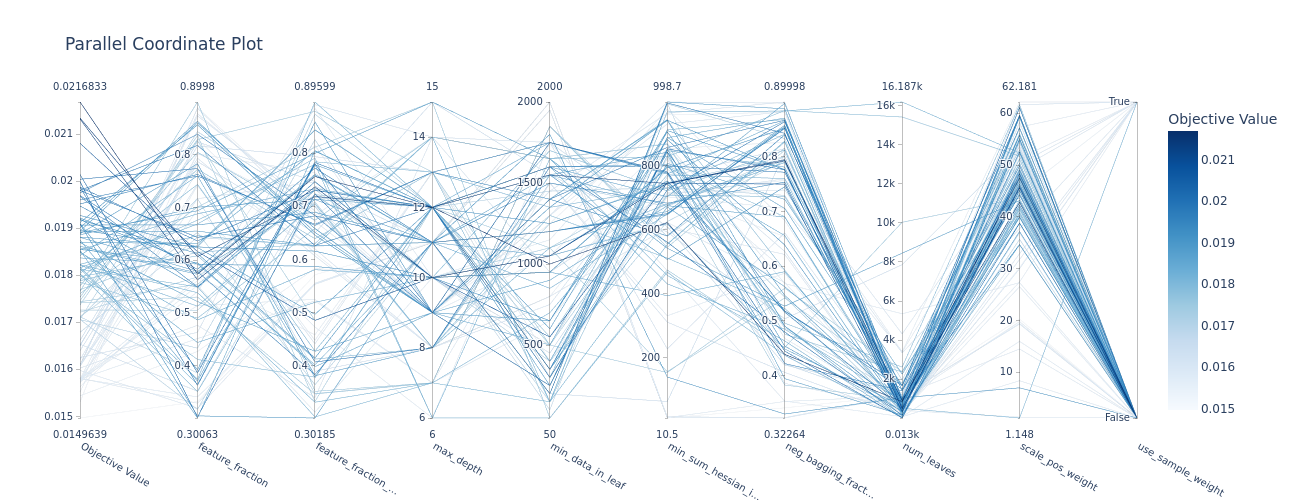

In [24]:
hpo_visualizer_lgb.plot_parallel_coordinate(
    figsize=(1300, 500),
    params=[
        "max_depth",
        "min_data_in_leaf",
        "min_sum_hessian_in_leaf",
        "neg_bagging_fraction",
        "feature_fraction",
        "feature_fraction_bynode",
        "num_leaves",
        "use_sample_weight",
        "scale_pos_weight",
    ],
)

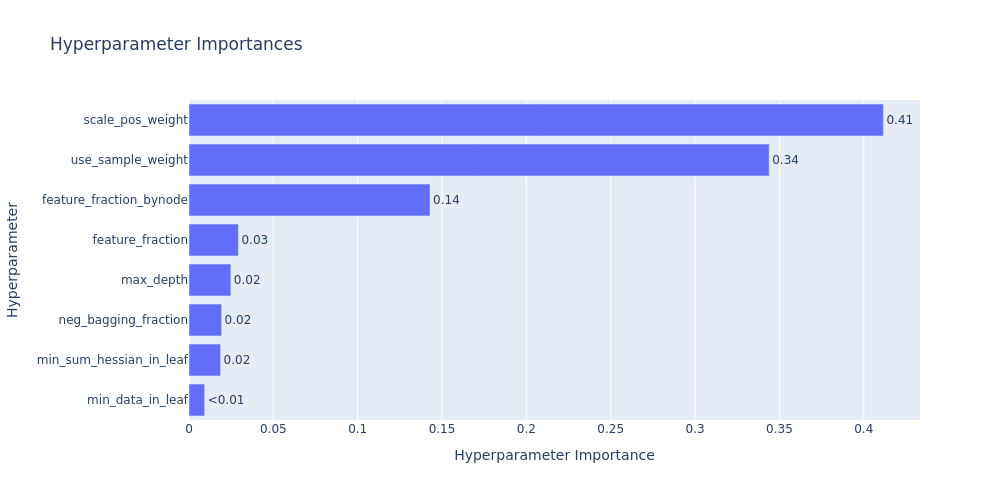

In [25]:
hpo_visualizer_lgb.plot_param_importances(figsize=(1000, 500))

### Best Model

In [9]:
best_model_s3_path_lgb = sm_client.describe_training_job(
    TrainingJobName=study_lgb.best_trial.user_attrs["job_name"]
)["ModelArtifacts"]["S3ModelArtifacts"]

print(f"Best model artifacts persisted at {best_model_s3_path_lgb}")

Best model artifacts persisted at s3://fraud-detection-classification/models/lightgbm-training-2025-01-03-22-15-15-078/output/model.tar.gz


In [38]:
!aws s3 cp $best_model_s3_path_lgb /tmp/model.tar.gz
!tar -xvzf /tmp/model.tar.gz -C /tmp

download: s3://fraud-detection-classification/models/lightgbm-training-2025-01-03-22-15-15-078/output/model.tar.gz to ../../../../../tmp/model.tar.gz
x best_model.joblib


In [ ]:
best_model_lgb = joblib.load("/tmp/best_model.joblib")
best_model_lgb.set_params(device_type="cpu")
best_model_lgb = clone(best_model_lgb)

best_model_lgb.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_train, y_train)],
    eval_names=["val"],
    eval_metric="average_precision",
    feature_name=X_train.columns,
    callbacks=[
        early_stopping(
            stopping_rounds=500,
            first_metric_only=True,
            verbose=True,
        )
    ],
)

best_model_lgb

In [10]:
y_val_prob_lgb = best_model_lgb.predict_proba(X_val)[:, 1]
y_val_prob_lgb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=450
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=659.405363153538, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=659.405363153538
[LightGBM] [Warning] feature_fraction is set=0.7481294919501177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7481294919501177


array([0.20718164, 0.08173785, 0.21429122, ..., 0.10063836, 0.22884872,
       0.10798867])

### Permutation Feature Importance

In [16]:
write_mode = False
if write_mode:
    perm_feat_imp_result_lgb = save_or_load_permutation_importance(
        estimator=best_model_lgb,
        X=X_val,
        y=y_val,
        model_s3_path=best_model_s3_path_lgb,
        write_mode=write_mode,
        scoring_function=make_scorer(
            average_precision_score,
            response_method="predict_proba",
            greater_is_better=True,
        ),
        random_state=random_state,
    )
else:
    perm_feat_imp_result_lgb = save_or_load_permutation_importance(
        estimator=best_model_lgb,
        X=X_val,
        y=y_val,
        model_s3_path=best_model_s3_path_lgb,
        write_mode=write_mode,
    )

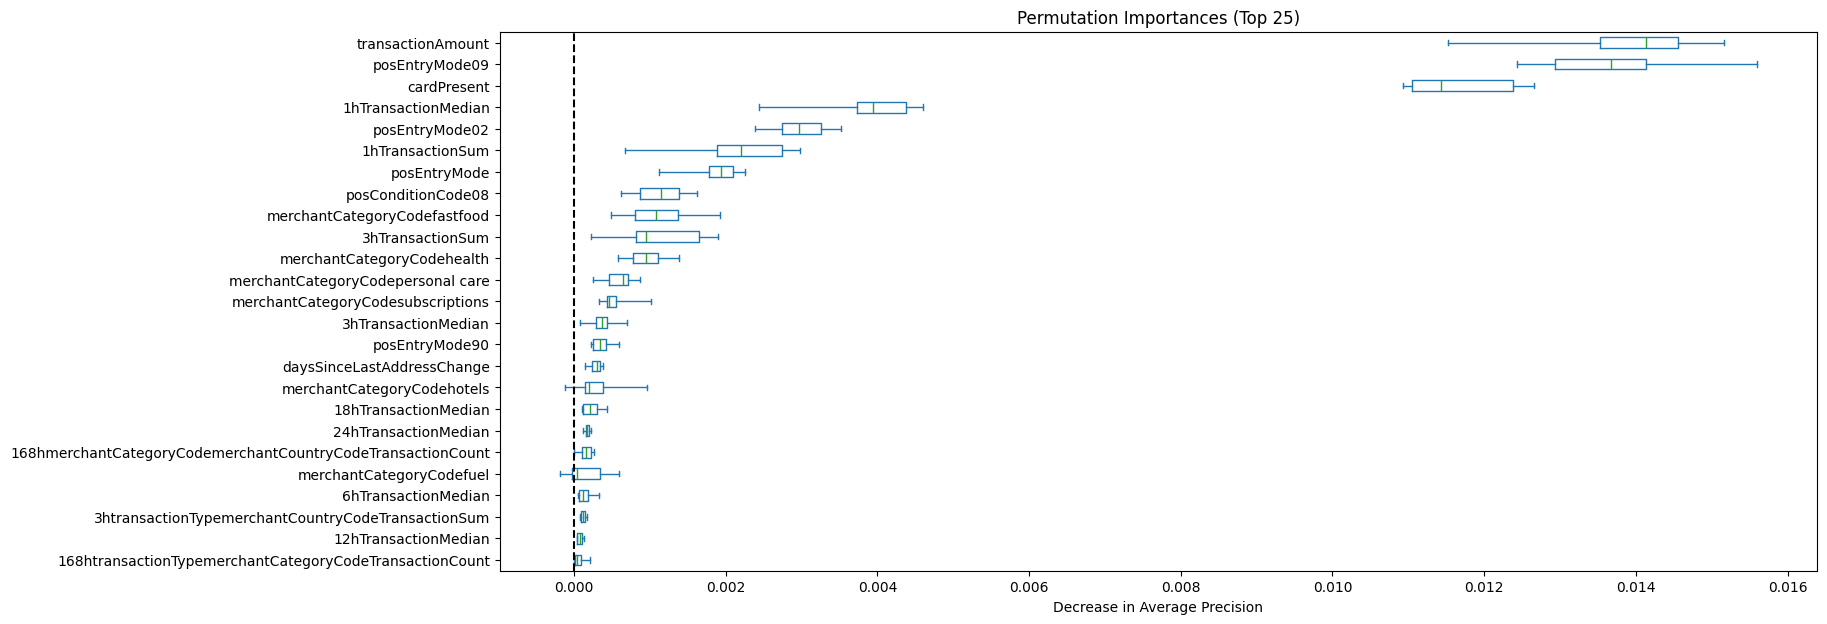

In [18]:
feat_impt_data = plot_permutation_importances(
    result=perm_feat_imp_result_lgb,
    feature_names=X_val.columns,
    top_k=25,
    metric_name="Average Precision",
    figsize=(17, 7),
)

### Calibration Curve

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=450
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=659.405363153538, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=659.405363153538
[LightGBM] [Warning] feature_fraction is set=0.7481294919501177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7481294919501177


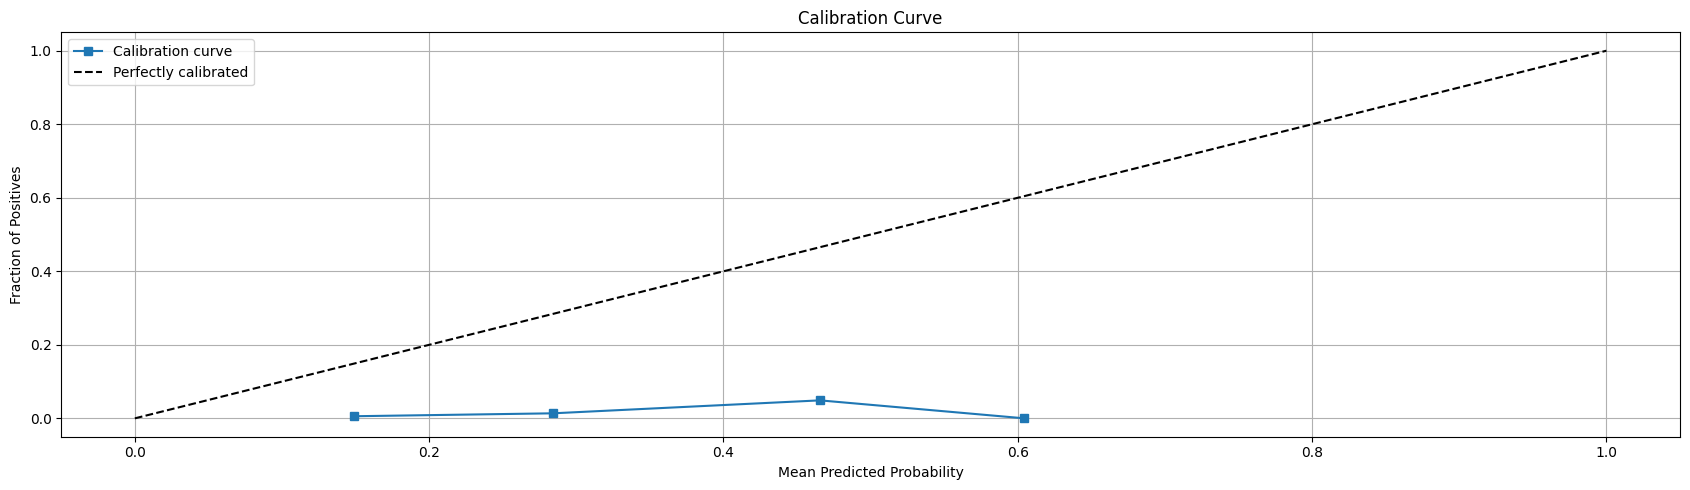

In [19]:
plot_calibration_curve(
    model=best_model_lgb,
    X=X_val,
    y_true=y_val,
    figsize=(17, 5),
)

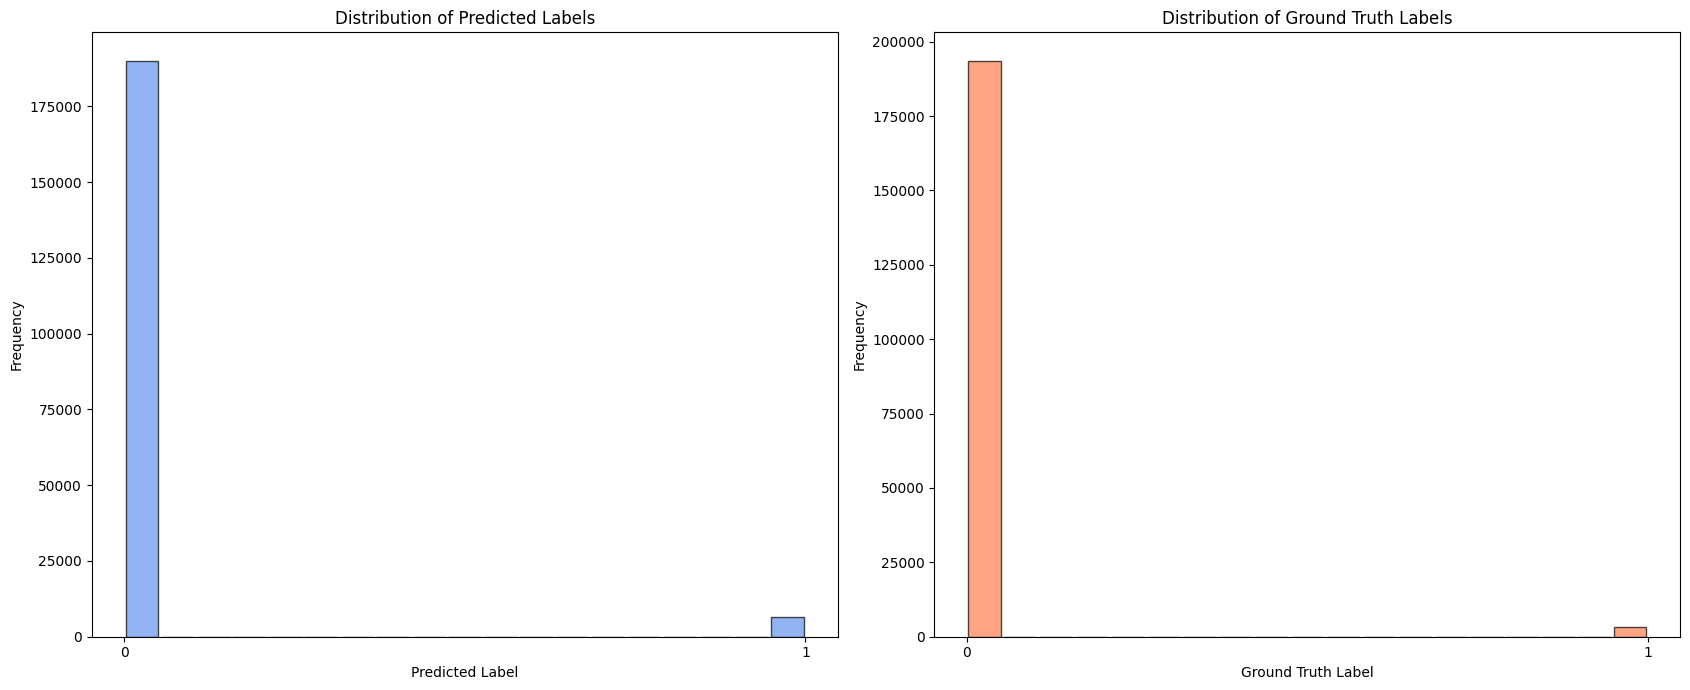

In [21]:
plot_prediction_vs_groundtruth(
    y_prob=y_val_prob_lgb,
    y_true=y_val,
    threshold=0.5,
    figsize=(17, 7),
)

### Cost Sensitive Treshold

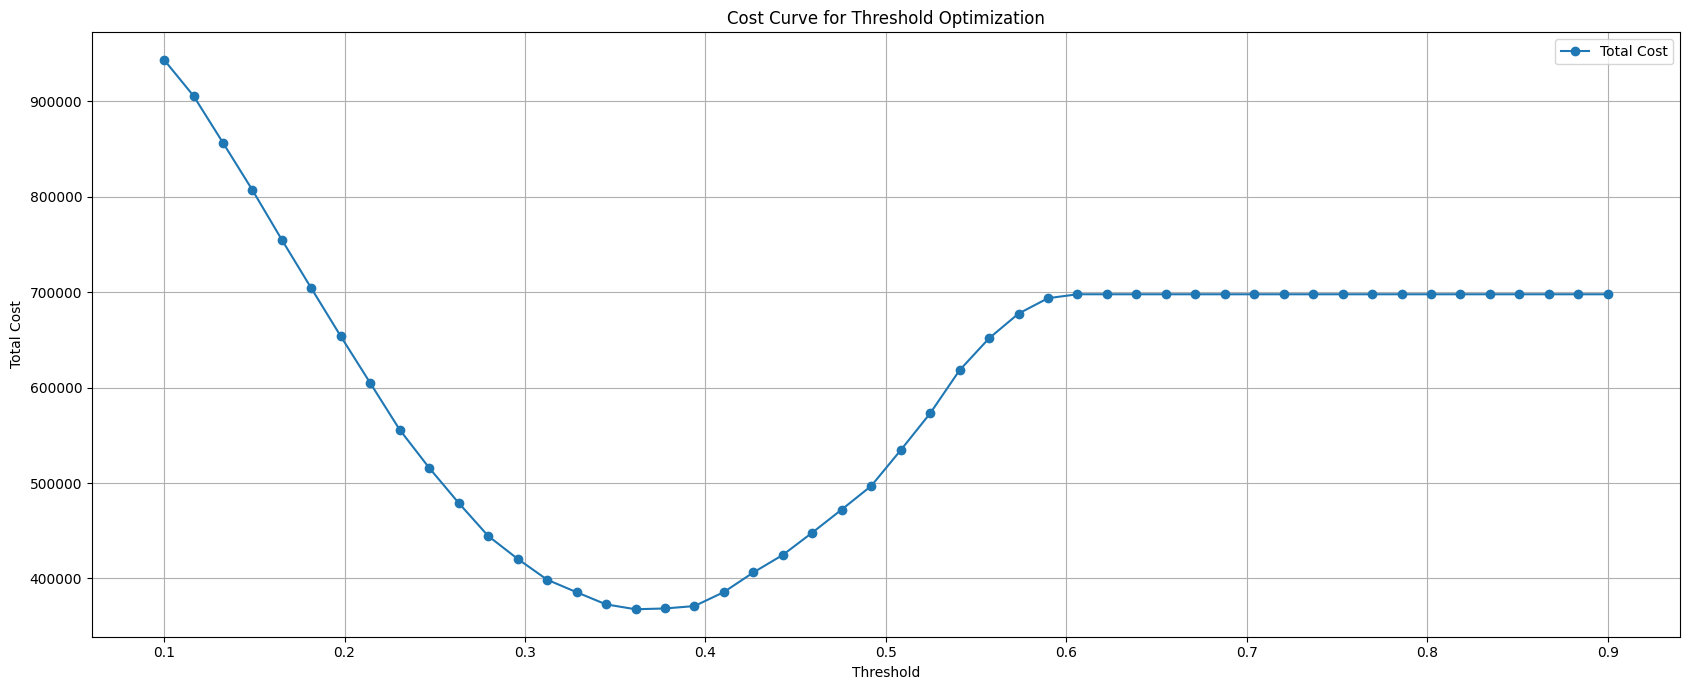

In [25]:
thresholds = np.linspace(0.10, 0.90, 50)

plot_cost_curve(
    y_prob=y_val_prob_lgb,
    y_true=y_val,
    transaction_amounts=transaction_amounts_val,
    false_positive_cost=false_positive_cost,
    thresholds=thresholds,
    figsize=(17, 7),
)

### Confusion Matrix

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=450
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=659.405363153538, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=659.405363153538
[LightGBM] [Warning] feature_fraction is set=0.7481294919501177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7481294919501177


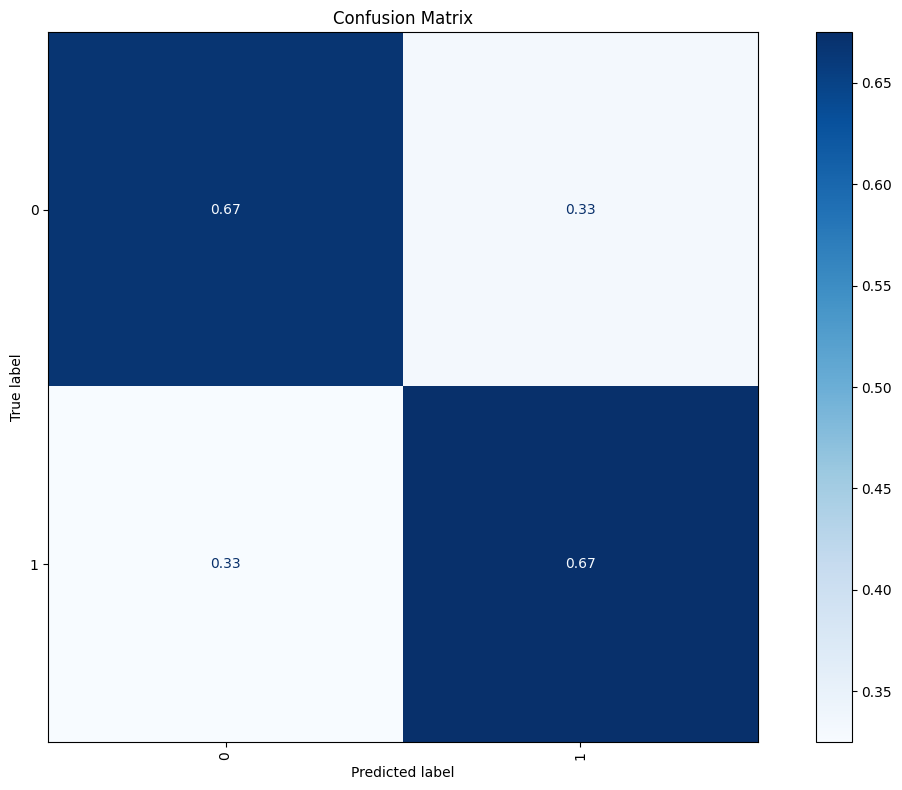

In [32]:
plot_confusion_matrix(
    model=best_model_lgb,
    X=X_val,
    y=y_val,
    figsize=(12, 8),
    threshold=0.3,
    normalize="true",
)

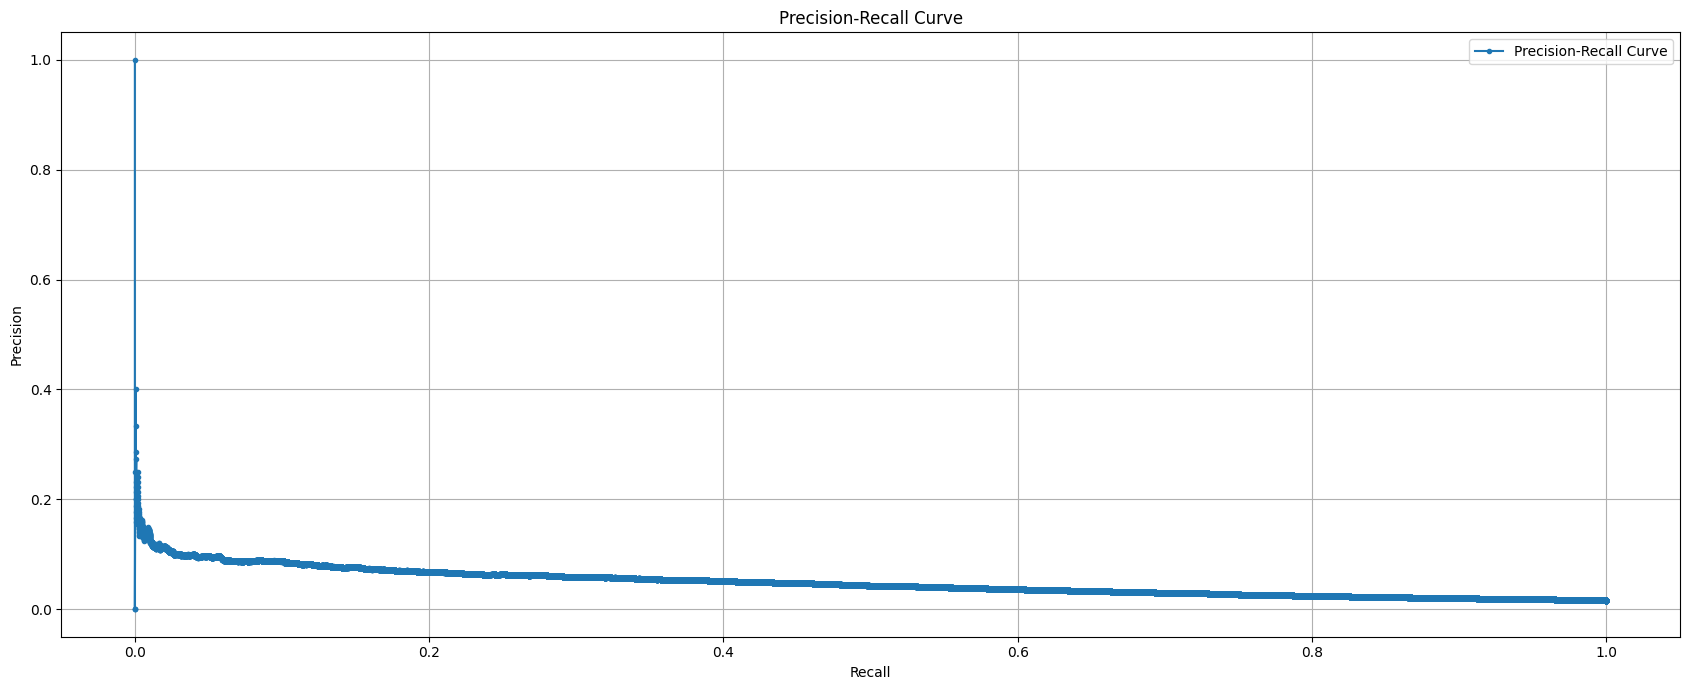

In [27]:
plot_precision_recall_curve(
    y_true=y_val,
    y_score=y_val_prob_lgb,
    figsize=(17, 7),
)

In [33]:
threshold = 0.3
print(classification_report(y_val, (y_val_prob_lgb > threshold).astype(int)))

              precision    recall  f1-score   support

           0       0.99      0.67      0.80    193487
           1       0.03      0.67      0.06      3104

    accuracy                           0.67    196591
   macro avg       0.51      0.67      0.43    196591
weighted avg       0.98      0.67      0.79    196591

